In [1]:
import json
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('torbens_tolle_timeseries.csv')
df['created_at'] = pd.to_datetime(df.created_at, utc=False)

In [3]:
# model training
def trainLM(df):
    X = np.array(df.loc[:, df.columns != 'count'])
    y = df['count']
    # Simple Model: Lin Reg. 
    #model = LinearRegression().fit(X, y)
    model = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_features = 'sqrt').fit(X,y)
    eval_df = df[['count']].copy()
    eval_df['pred'] = model.predict(X)
    #print('Koeffizienten: ', model.coef_,' Intercept: ',model.intercept_)
    print("Feature Importance: \n", pd.Series(model.feature_importances_, index=df.loc[:, df.columns != 'count'].columns).sort_values(ascending=False)) 
    print('Test auf Train_Daten __________:')
    print("Mean Squared Error: ",mean_squared_error(eval_df['count'], eval_df.pred))
    print("R2_Score: ", r2_score(eval_df['count'], eval_df.pred))
    print('Number of rows: ',len(df))
    return eval_df, model

In [4]:
# Compute next timestamps for hourly pred
def next_nh_timestamps(timeseries, n):
    """ Input: timeseries in 1 h chunks, n -> Number of next timestemps"""
    forecast = []
    year = timeseries.tail(1).index[0].year
    month = timeseries.tail(1).index[0].month
    day = timeseries.tail(1).index[0].day
    hour = timeseries.tail(1).index[0].hour
    minute = timeseries.tail(1).index[0].minute
    for el in range(n):
        hour +=1
        if hour == 24:
            hour =0
            day += 1
            if day == 31:
                day = 1
                month += 1
                if month == 13:
                    month = 1
                    year += 1
        forecast.append(pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute))
    return forecast

In [5]:
# Needed help function because we need to loop several times over this to get all the t1-5 shifts done
def perform_shifts(df):
    df['t-1'] = df['count'].shift(1)
    df['t-2'] = df['count'].shift(2)
    df['t-3'] = df['count'].shift(3)
    df['t-4'] = df['count'].shift(4)
    df['t-5'] = df['count'].shift(5)
    return df

In [6]:
# Method for Feature engineering
def feature_engineering(ts):
    new = next_nh_timestamps(ts, 24)
    countfake = np.full((len(new),1), np.nan) 
    df_1d = pd.DataFrame(countfake, index =new, columns=['count'])
    df_1d.index = df_1d.index.astype('datetime64[ns, UTC]')
    ts = pd.concat([ts,df_1d])
    
    # Feature Engineering
    ts['month'] = ts['count'].index.month
    ts['week'] = ts['count'].index.week
    ts['hour'] = ts['count'].index.hour
    #days to election
    ts['days_to_election'] = (pd.Timestamp(year=2017,month=9,day=24, tz= 'UTC')-ts.index).days
    # Add mean monthly tweets to remove monthly fluctuation
    ts['month_avg'] = ts[['count']].groupby([ts.index.month]).transform('mean')
    # Add mean weekly tweets to remove weekly fluctuation
    ts['week_avg'] = ts[['count']].groupby([ts.index.week]).transform('mean')
    # Add mean hourly tweets to remove daily fluctuation
    ts['day_avg'] = ts[['count']].groupby([ts.index.day]).transform('mean')
    # Integrate Day as binary
    ts['day'] = 0
    ts.loc[(ts.index.hour > 6) & (ts.index.hour<=18),'day'] = 1
    # Integrate Workday as binary
    ts['Workday'] = 1
    ts.loc[(ts.index.weekday == 5 )|(ts.index.weekday == 6),'Workday'] = 0
    # Integrate AR for 24 h ago -> look 24 steps back as data is stored in chunks of 1 h
    ts['t-24'] = ts['count'].shift(24)
    # Integrate AR for 1 week ago -> look 24*7 steps back as data is stored in chunks of 1 h
    if ts.shape[0] > 168:
        ts['t-168'] = ts['count'].shift(168)
    else:
        pass
    # Integrate AR of past 5 Sessions -> no theoretical reasoning for usage, decreases MSE by roughly 10 percent, no decrease in r2
    ts['t-1'] = ts['count'].shift(1)
    ts['t-2'] = ts['t-1'].shift(1)
    ts['t-3'] = ts['t-2'].shift(1)
    ts['t-4'] = ts['t-3'].shift(1)
    ts['t-5'] = ts['t-4'].shift(1)
    ts['time'] = (ts.index - ts.index[0]).days
    return ts

## Implementation for 1h Chunks

In [7]:
# complete pipeline for 1h predictions
def timeseries_analysis_h(df, party=False):
    """Function to perform forecast for next day & week
       Takes oroginal DF and party = Partyname if forecast for specific party is required
    """
    if party:
        ts = df.groupby([pd.Grouper(key="created_at", freq="1h"), pd.Grouper('party_ref')]).count()[['user.id']].reset_index().rename(columns={'author_party':'Party','user.id':'count'}).set_index('created_at') 
        ts = ts[ts['party_ref']=='Grüne'].drop('party_ref',axis=1)
    else:
        ts = df.groupby(pd.Grouper(key="created_at", freq="1h")).count()[['user.id']].rename(columns={'user.id':'count'})
    
    # Add Timestamps for the forecast period: next 24 hours
    # Cut last day as testset
    train = ts.iloc[:-24]
    test = ts.iloc[-24:]
    # Feature Engineering
    ts = feature_engineering(ts)
    train = feature_engineering(train)
    
    # save a worker version without dropped columns
    # to reduce complexity only work on tail of df 
    timeseries_worker = ts.iloc[-240:]
    timeseries_worker2 = train.iloc[-240:]
    
    # drop na as first x rows are not filled due to shift operation
    ts.dropna(inplace=True)
    train.dropna(inplace=True)
    
    # train models
    eva_test,model_test =trainLM(train)
    eva_forecast, model_forecast = trainLM(ts)
    
    # Compute shift operations for actual forecast
    for el in range(24):
        # Insert predicting into "count" column
        timeseries_worker.iloc[-24+el, timeseries_worker.columns.get_loc('count')] = 0 if model_forecast.predict(np.array(timeseries_worker.loc[:, timeseries_worker.columns != 'count'].iloc[-24+el:].iloc[0]).reshape(1,-1))[0].round(0)<0 else model_forecast.predict(np.array(timeseries_worker.loc[:, timeseries_worker.columns != 'count'].iloc[-24+el:].iloc[0]).reshape(1,-1))[0].round(0)
        # perform shifting operations again 
        timeseries_worker = perform_shifts(timeseries_worker)
    # Compute shift operations for test 
    for el in range(24):
        # Insert predicting into "count" column
        timeseries_worker2.iloc[-24+el, timeseries_worker2.columns.get_loc('count')] = 0 if model_test.predict(np.array(timeseries_worker2.loc[:, timeseries_worker2.columns != 'count'].iloc[-24+el:].iloc[0]).reshape(1,-1))[0].round(0)<0 else model_test.predict(np.array(timeseries_worker2.loc[:, timeseries_worker2.columns != 'count'].iloc[-24+el:].iloc[0]).reshape(1,-1))[0].round(0)
        # perform shifting operations again 
        timeseries_worker2 = perform_shifts(timeseries_worker2)
    
    #calculate testscores for testset
    df_testscores = pd.concat([timeseries_worker2.iloc[-24:][['count']].rename(columns={'count':'pred'}),ts.iloc[-24:][['count']].rename(columns={'count':'actual'})],axis=1)
    
    # Plot Forecast
    one_w_ago = timeseries_worker[['count']].iloc[-216:-192].reset_index(drop=True)
    one_d_ago = timeseries_worker[['count']].iloc[-48:-24].reset_index(drop=True)
    forecast = timeseries_worker[['count']].iloc[-24:]
    grouped_visuals = pd.concat([one_w_ago.rename(columns={'count':'one_w_ago'}),one_d_ago.rename(columns={'count':'one_d_ago'}),timeseries_worker[['count']].iloc[-24:].reset_index(drop=True).rename(columns={'count':'pred'})],axis=1)
    
    return eva_test, df_testscores, forecast, grouped_visuals

In [8]:
# export to csv only forecast dataframe, contains the 24 predictions
eva_test, df_testscores, forecast, grouped_visuals=timeseries_analysis_h(df)

Feature Importance: 
 t-1                 0.306937
t-2                 0.093216
hour                0.085966
day_avg             0.080413
t-24                0.066077
t-3                 0.059404
t-168               0.051283
t-4                 0.050721
t-5                 0.047671
days_to_election    0.038018
time                0.037912
day                 0.029734
week_avg            0.022349
week                0.011665
Workday             0.007292
month_avg           0.005974
month               0.005368
dtype: float64
Test auf Train_Daten __________:
Mean Squared Error:  3238.8007855835804
R2_Score:  0.9319101560754
Number of rows:  1011
Feature Importance: 
 t-1                 0.311765
t-2                 0.093783
day_avg             0.080495
hour                0.080424
t-24                0.064846
t-3                 0.056224
t-168               0.050880
t-4                 0.050847
t-5                 0.043885
time                0.042232
days_to_election    0.040558
day    

<AxesSubplot:title={'center':'Visual Validation'}>

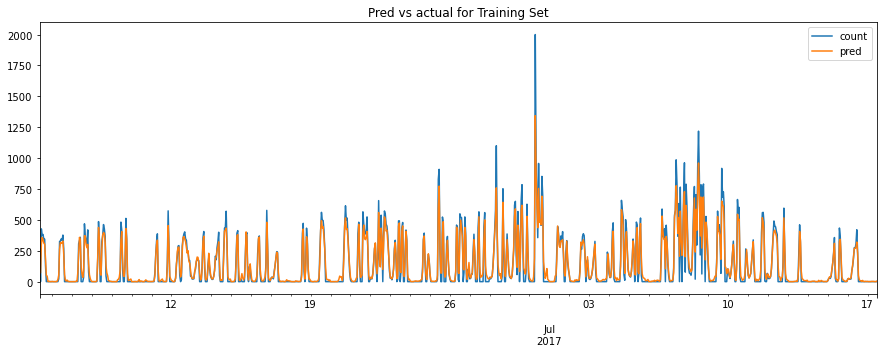

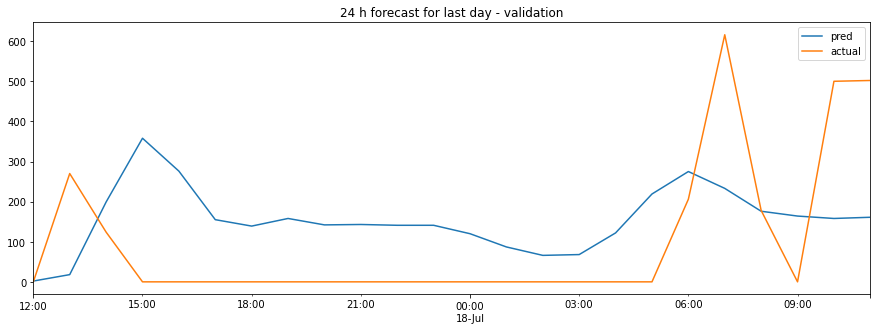

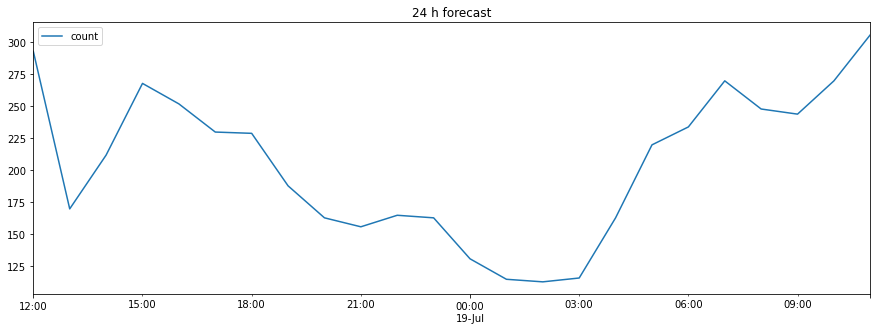

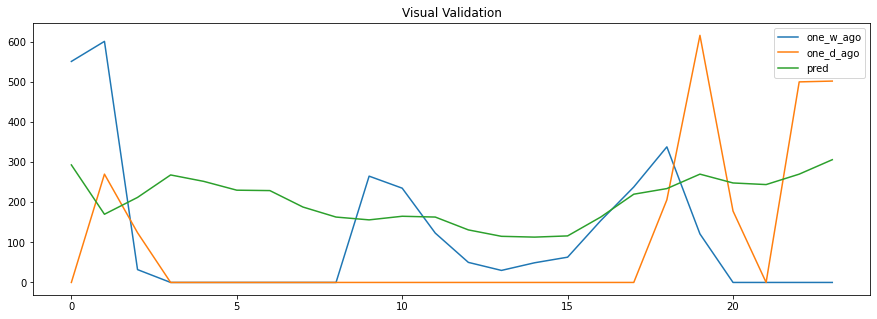

In [9]:
eva_test.plot(figsize=(15,5), title = 'Pred vs actual for Training Set')
df_testscores.plot(figsize=(15,5), title = f'24 h forecast for last day - validation')
forecast.plot(figsize=(15,5), title = f'24 h forecast')
grouped_visuals.plot(figsize=(15,5), title = 'Visual Validation')

## Implementation for 5 min Chunks - not relevant -

In [6]:
# Compute next timestamps
def next_n_timestamps(timeseries, n):
    """ Input: timeseries in 5 min chunks, n -> Number of next timestemps"""
    forecast = []
    year = timeseries.tail(1).index[0].year
    month = timeseries.tail(1).index[0].month
    day = timeseries.tail(1).index[0].day
    hour = timeseries.tail(1).index[0].hour
    minute = timeseries.tail(1).index[0].minute
    for el in range(n):
        minute +=5
        if minute == 60:
            minute = 0
            hour +=1
            if hour == 24:
                hour =0
                day += 1
                if day == 31:
                    day = 1
                    month += 1
                    if month == 13:
                        month = 1
                        year += 1
        forecast.append(pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute, second = 0, microsecond = 0))
    return forecast

In [12]:
# complete pipeline
def timeseries_analysis(df, party=False):
    """Function to perform forecast for next day & week
       Takes oroginal DF and party = Partyname if forecast for specific party is required
    """
    if party:
        ts = df.groupby([pd.Grouper(key="created_at", freq="5min"), pd.Grouper('party_ref')]).count()[['user.id']].reset_index().rename(columns={'author_party':'Party','user.id':'count'}).set_index('created_at') 
        ts = ts[ts['party_ref']=='Grüne'].drop('party_ref',axis=1)
    else:
        ts = df.groupby(pd.Grouper(key="created_at", freq="5min")).count()[['user.id']].rename(columns={'user.id':'count'})
    
    # Add Timestamps for the forecast period: next 24 hours
    new = next_n_timestamps(ts, 288)
    countfake = np.full((len(new),1), np.nan) 
    df_1d = pd.DataFrame(countfake, index =new, columns=['count'])
    df_1d.index = df_1d.index.astype('datetime64[ns, UTC]')
    ts = pd.concat([ts,df_1d])
    
    # Feature Engineering
    ts['month'] = ts['count'].index.month
    ts['week'] = ts['count'].index.week
    ts['hour'] = ts['count'].index.hour
    ts['minute'] = ts['count'].index.minute
    #days to election
    ts['days_to_election'] = (pd.Timestamp(year=2017,month=9,day=24, tz= 'UTC')-ts.index).days
    # Add mean monthly tweets to remove monthly fluctuation
    ts['month_avg'] = ts[['count']].groupby([ts.index.month]).transform('mean')
    # Add mean weekly tweets to remove weekly fluctuation
    ts['week_avg'] = ts[['count']].groupby([ts.index.week]).transform('mean')
    # Add mean hourly tweets to remove hourly fluctuation
    ts['hour_avg'] = ts[['count']].groupby([ts.index.hour]).transform('mean')
    # Integrate Day as binary
    ts['day'] = 0
    ts.loc[(ts.index.hour > 6) & (ts.index.hour<=18),'day'] = 1
    # Integrate Workday as binary
    ts['Workday'] = 1
    ts.loc[(ts.index.weekday == 5 )|(ts.index.weekday == 6),'Workday'] = 0
    # Integrate AR for 24 h ago -> look 24*12 steps back as data is stored in chunks of 5 min
    ts['t-288'] = ts['count'].shift(288)
    # Integrate AR for 1 week ago -> look 24*12*7 steps back as data is stored in chunks of 5 min
    if ts.shape[0] > 2016:
        ts['t-2016'] = ts['count'].shift(2016)
    else:
        pass
    # Integrate AR of past 5 Sessions -> no theoretical reasoning for usage, decreases MSE by roughly 10 percent, no decrease in r2
    ts['t-1'] = ts['count'].shift(1)
    ts['t-2'] = ts['t-1'].shift(1)
    ts['t-3'] = ts['t-2'].shift(1)
    ts['t-4'] = ts['t-3'].shift(1)
    ts['t-5'] = ts['t-4'].shift(1)
    ts['time'] = (ts.index - ts.index[0]).days
    # save a worker version without dropped columns
    worker_df = ts.copy()
    # drop na as first x rows are not filled due to shift operation
    ts.dropna(inplace=True)
    
    # train model
    eva,model =trainLM(ts)
    
    # to reduce complexity only work on tail of df
    timeseries_worker = worker_df.iloc[-600:]

    # Compute shift operations for forecast
    for el in range(288):
        # Insert predicting into "count" column
        timeseries_worker.iloc[-288+el, timeseries_worker.columns.get_loc('count')] = model.predict(np.array(timeseries_worker.loc[:, timeseries_worker.columns != 'count'].iloc[-288+el:].iloc[0]).reshape(1,-1))[0].round(0)
        # perform shifting operations again 
        timeseries_worker = perform_shifts(timeseries_worker)
    
    # Plot Forecast
    last_d = timeseries_worker[['count']].iloc[-576:-288].plot(figsize=(15,5), title = "last_d")
    forecast = timeseries_worker[['count']].iloc[-288:].plot(figsize=(15,5), title= f'24 h forecast for {party}')
    
    return last_d, forecast, eva, timeseries_worker.iloc[-50:]

## Try Arma impementation - not relevant

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def evalARMA(model, df, mkplot=True):
    eval_df = df[['count']].copy()
    eval_df['pred'] = model.predict()
    print("Mean Squared Error: ",mean_squared_error(eval_df['count'], eval_df.pred))
    if mkplot:
        eval_df.iloc[1:100].plot(figsize=(15,5))
        eval_df.plot(figsize=(15,5))

Mean Squared Error:  93.99133193548779


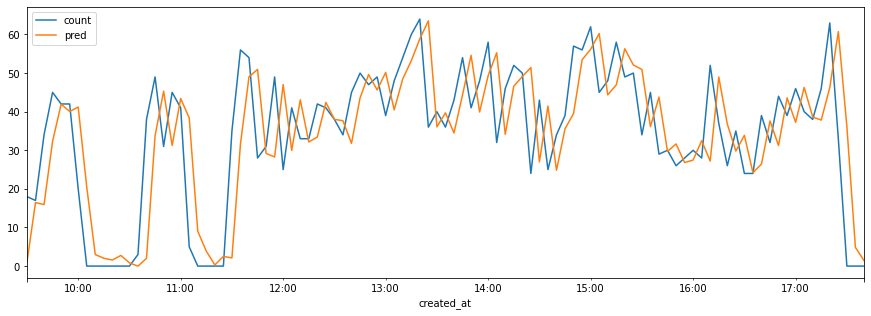

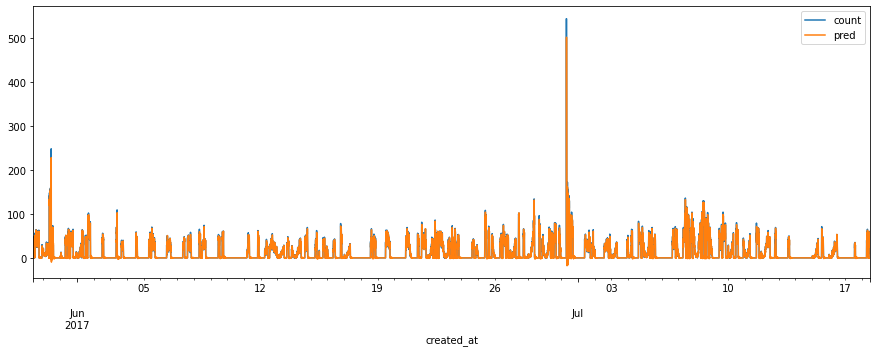

In [17]:
dfa = df.groupby(pd.Grouper(key="created_at", freq="5min")).count()[['user.id']].rename(columns={'user.id':'count'})
arma = SARIMAX(dfa[['count']], order=(5,1,0), seasonal_order=(4,0,0,12)  ).fit() # ARMA handles univariate time series only and does its own time-shifting
evalARMA(arma, dfa)